In [1]:
import os
from pathlib import Path
script_dir = os.path.dirname(Path().resolve())
os.chdir(script_dir)
os.makedirs(os.path.join(script_dir, 'output'), exist_ok=True)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

from src.recursive_token_chunker import RecursiveTokenChunker
from src.Embedding import GPTEmbedding
from src.EvaluationPipeline import EvaluationPipeline
from src.Utils import Utils

In [2]:
gpt_df = pd.read_csv(os.path.join('output', 'gpt_results.csv'))

Below are results of experiments with different chunkers and hyperparameters along with metrics' means and standard deviations.

In [3]:
def format_mean_std(mean, std):
    return f"{mean:.3f} ± {std:.3f}"

In [4]:
metrics = ['iou', 'recall', 'precision']
gpt_df_view = gpt_df.copy()
for metric in metrics:
    gpt_df_view[metric] = gpt_df_view.apply(lambda x: format_mean_std(x[metric+'_score'], x[metric+'_score_std']), axis=1)
    gpt_df_view = gpt_df_view.drop(columns=[metric+'_score', metric+'_score_std'])
gpt_df_view

,chunker,chunk_size,overlap_size,top_k,iou,recall,precision
0,fixed-size,800,400,5,0.014 ± 0.009,0.940 ± 0.231,0.014 ± 0.009
1,fixed-size,800,400,10,0.007 ± 0.004,0.999 ± 0.017,0.007 ± 0.004
2,fixed-size,800,400,Min,0.029 ± 0.025,0.771 ± 0.414,0.029 ± 0.025
3,recursive,800,400,5,0.016 ± 0.011,0.920 ± 0.268,0.016 ± 0.011
4,recursive,800,400,10,0.009 ± 0.005,0.983 ± 0.123,0.009 ± 0.005
5,recursive,800,400,Min,0.038 ± 0.036,0.721 ± 0.445,0.038 ± 0.036
6,fixed-size,800,200,5,0.014 ± 0.009,0.940 ± 0.228,0.014 ± 0.009
7,fixed-size,800,200,10,0.008 ± 0.004,0.995 ± 0.062,0.008 ± 0.004
8,fixed-size,800,200,Min,0.035 ± 0.039,0.613 ± 0.478,0.035 ± 0.039
9,recursive,800,200,5,0.017 ± 0.010,0.955 ± 0.203,0.017 ± 0.010


In [5]:
filtered_gpt_df = gpt_df.groupby(['top_k']).agg({'precision_score': 'mean', 'recall_score': 'mean'}).reset_index()
filtered_gpt_df

,top_k,precision_score,recall_score
0,10,0.018039,0.987010
1,5,0.034103,0.938249
2,Min,0.099730,0.684293


The top_k parameter once again demonstrates precision-recall tradeoff, just like in sentence-transformer evaluation.

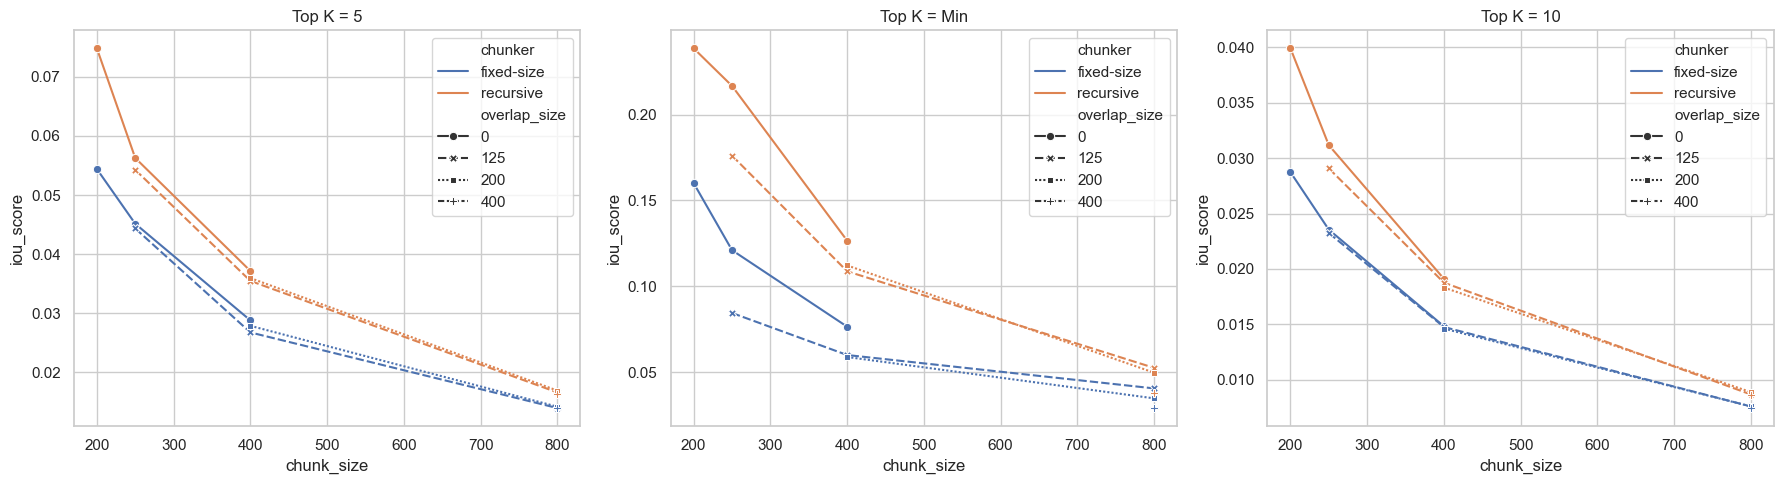

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

sns.lineplot(
    data=gpt_df[gpt_df['top_k'] == '5'],
    x='chunk_size',
    y='iou_score',
    hue='chunker',
    style='overlap_size',
    markers=True,
    ax=ax1
)
ax1.set_title('Top K = 5')

sns.lineplot(
    data=gpt_df[gpt_df['top_k'] == 'Min'],
    x='chunk_size',
    y='iou_score',
    hue='chunker',
    style='overlap_size',
    markers=True,
    ax=ax2
)
ax2.set_title('Top K = Min')

sns.lineplot(
    data=gpt_df[gpt_df['top_k'] == '10'],
    x='chunk_size',
    y='iou_score',
    hue='chunker',
    style='overlap_size',
    markers=True,
    ax=ax3
)
ax3.set_title('Top K = 10')

plt.tight_layout()

We can take the mean iou_score for every chunk_size and visualize it better.

<Axes: xlabel='chunk_size', ylabel='iou_score'>

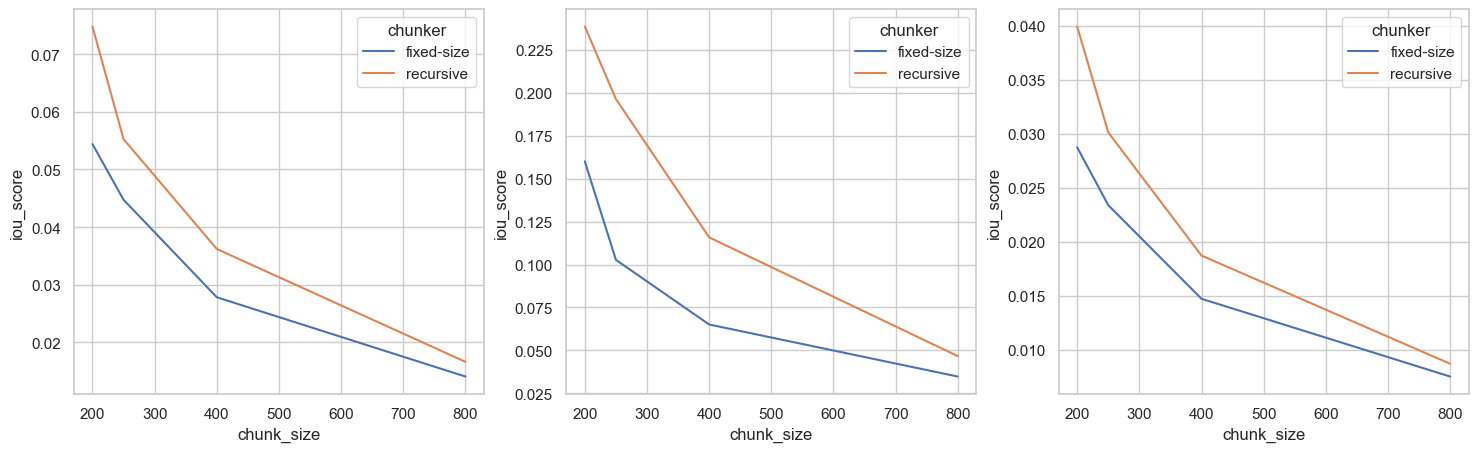

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
filtered_gpt_df = gpt_df.groupby(['chunker', 'chunk_size', 'top_k']).agg({'iou_score': 'mean'}).reset_index()
sns.lineplot(data=filtered_gpt_df[filtered_gpt_df['top_k'] == '5'], x='chunk_size', y='iou_score', hue='chunker', ax=ax1)
sns.lineplot(data=filtered_gpt_df[filtered_gpt_df['top_k'] == 'Min'], x='chunk_size', y='iou_score', hue='chunker', ax=ax2)
sns.lineplot(data=filtered_gpt_df[filtered_gpt_df['top_k'] == '10'], x='chunk_size', y='iou_score', hue='chunker', ax=ax3)

Again, iou_score decreases with increasing chunk_size.
Also, recursive chunking is still the best choice.

Text(0.5, 1.0, 'Performance Distribution by Chunker and Top-K')

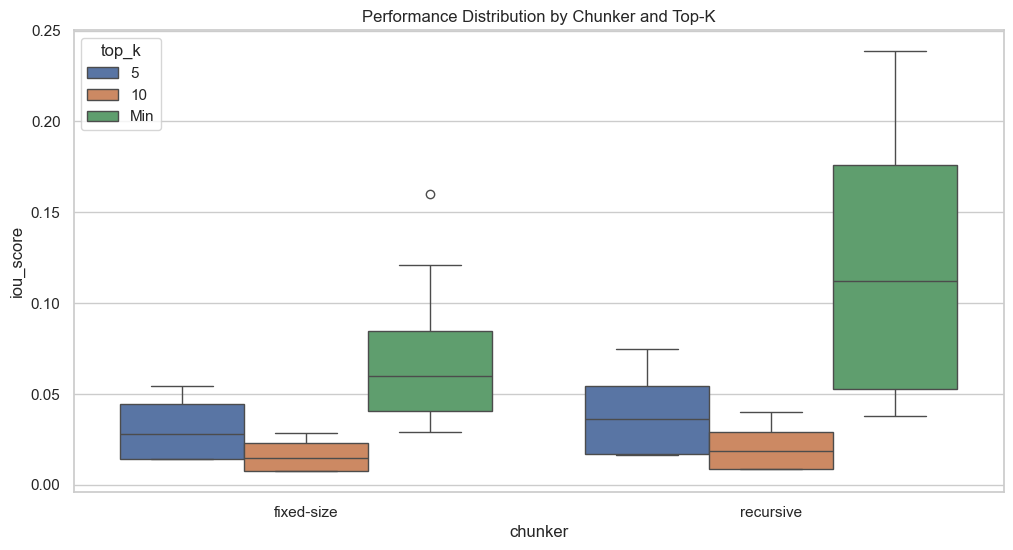

In [8]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=gpt_df, x='chunker', y='iou_score', hue='top_k')
plt.title('Performance Distribution by Chunker and Top-K')

Similar results as in experiments_st.ipynb notebook.

Text(0.5, 1.0, 'Standard Deviation Heatmap: Chunk Size vs Overlap')

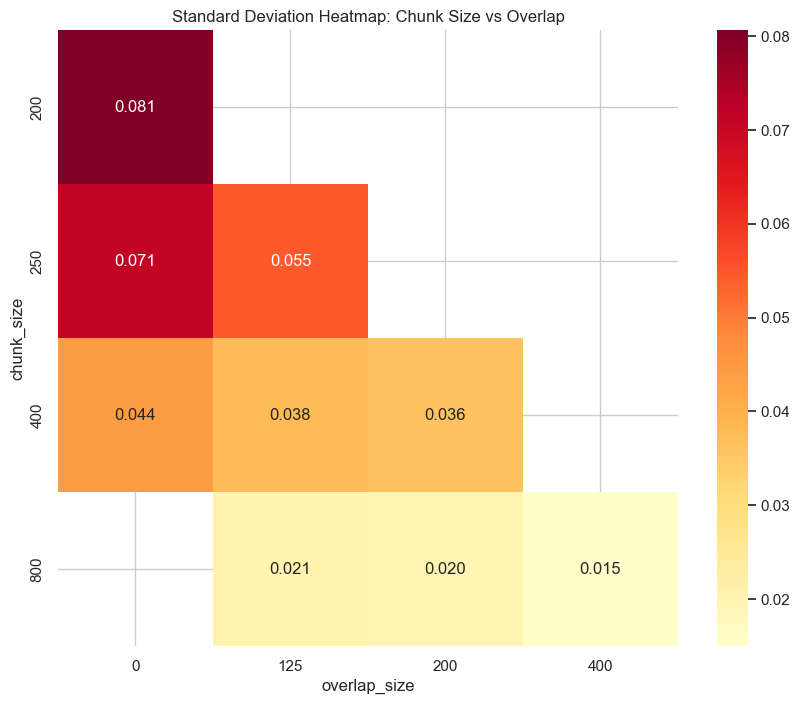

In [9]:
pivot_std = gpt_df.pivot_table(
    values='iou_score_std',
    index='chunk_size',
    columns='overlap_size',
    aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_std, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Standard Deviation Heatmap: Chunk Size vs Overlap')

And again, similar results as in previous notebook.

Let's extract the maximum values of recall, iou, and precision for each top_k configuration.

In [10]:
def max_values(df):
    max_recall = df.loc[df['recall'].idxmax()]
    max_iou = df.loc[df['iou'].idxmax()]
    max_precision = df.loc[df['precision'].idxmax()]
    
    return max_recall, max_iou, max_precision

In [11]:
gpt_max_all = pd.DataFrame()

for k in ['5', '10', 'Min']:
    df = gpt_df_view[gpt_df_view['top_k'] == k]
    max_gpt_recall, max_gpt_iou, max_gpt_precision = max_values(df)
    
    gpt_max = pd.DataFrame([max_gpt_recall, max_gpt_iou, max_gpt_precision], 
                          index=['max-recall', 'max-iou', 'max-precision'])
    
    gpt_max_all = pd.concat([gpt_max_all, gpt_max], axis=0)
    
gpt_max_all

,chunker,chunk_size,overlap_size,top_k,iou,recall,precision
max-recall,recursive,800,125,5,0.017 ± 0.010,0.969 ± 0.168,0.017 ± 0.010
max-iou,recursive,200,0,5,0.075 ± 0.046,0.942 ± 0.222,0.075 ± 0.046
max-precision,recursive,200,0,5,0.075 ± 0.046,0.942 ± 0.222,0.075 ± 0.046
max-recall,recursive,800,200,10,0.009 ± 0.005,1.000 ± 0.000,0.009 ± 0.005
max-iou,recursive,200,0,10,0.040 ± 0.023,0.975 ± 0.148,0.040 ± 0.023
max-precision,recursive,200,0,10,0.040 ± 0.023,0.975 ± 0.148,0.040 ± 0.023
max-recall,fixed-size,400,200,Min,0.059 ± 0.048,0.785 ± 0.387,0.059 ± 0.049
max-iou,recursive,200,0,Min,0.239 ± 0.229,0.689 ± 0.438,0.242 ± 0.230
max-precision,recursive,200,0,Min,0.239 ± 0.229,0.689 ± 0.438,0.242 ± 0.230


We can conduct few interesting configurations of hyperparameters:

#### Highest IoU/Precision Configuration
- Chunker: Recursive
- Chunk Size: 200
- Overlap Size: 0
- Top K: Min

#### Highest Recall Configuration
- Chunker: Recursive
- Chunk Size: 800
- Overlap Size: 200
- Top K: 10

#### Overall Well-Performing Configurations
##### Configuration 1
- Chunker: Recursive
- Chunk Size: 200
- Overlap Size: 0
- Top K: 5
##### Configuration 2
- Chunker: Recursive
- Chunk Size: 250
- Overlap Size: 125
- Top K: Min
##### Configuration 3
- Chunker: Recursive
- Chunk Size: 250
- Overlap Size: 0
- Top K: Min

Therefore, let's evaluate the performance of the well-performing configurations with reranker=True.

In [12]:
metrics_list = []

pipeline = EvaluationPipeline(RecursiveTokenChunker(chunk_size=200, chunk_overlap=0, length_function=Utils.cl100k_base_length), 
                              GPTEmbedding(), 
                              top_k=5, 
                              reranker=True)
metrics_mean, metrics_std = pipeline.evaluate_retrievals('wikitexts', False)
metrics_list.append({**metrics_mean, **metrics_std})

Reranking documents...


Reranking Progress: 100%|██████████| 144/144 [03:47<00:00,  1.58s/it]


In [ ]:
pipeline = EvaluationPipeline(RecursiveTokenChunker(chunk_size=250, chunk_overlap=125, length_function=Utils.cl100k_base_length),
                              GPTEmbedding(),
                              top_k=5,
                              reranker=True)
metrics_mean, metrics_std = pipeline.evaluate_retrievals('wikitexts', True)
metrics_list.append({**metrics_mean, **metrics_std})

In [ ]:
pipeline = EvaluationPipeline(RecursiveTokenChunker(chunk_size=250, chunk_overlap=0, length_function=Utils.cl100k_base_length),
                              GPTEmbedding(),
                              top_k=5,
                              reranker=True)
metrics_mean, metrics_std = pipeline.evaluate_retrievals('wikitexts', True)
metrics_list.append({**metrics_mean, **metrics_std})

In [ ]:
pipeline = EvaluationPipeline(RecursiveTokenChunker(chunk_size=200, chunk_overlap=0, length_function=Utils.cl100k_base_length), 
                              GPTEmbedding(), 
                              top_k=5, 
                              reranker=True)
metrics_mean, metrics_std = pipeline.evaluate_retrievals('wikitexts', True)
metrics_list.append({**metrics_mean, **metrics_std})

In [ ]:
pipeline = EvaluationPipeline(RecursiveTokenChunker(chunk_size=800, chunk_overlap=200, length_function=Utils.cl100k_base_length), 
                              GPTEmbedding(), 
                              top_k=10, 
                              reranker=True)
metrics_mean, metrics_std = pipeline.evaluate_retrievals('wikitexts', False)
metrics_list.append({**metrics_mean, **metrics_std})

In [19]:
df = pd.DataFrame(metrics_list,
                  index=['Recursive-200-0-5', 'Recursive-250-125-Min', 'Recursive-250-0-Min', 'Recursive-200-0-Min', 'Recursive-800=200-10'])
df.to_csv(os.path.join('output', 'reranker_results.csv'), index=True)

In [ ]:
df